# Lasso Regression for Identifying Age At Onset of Alcohol Abuse #

** Submitted as part of Machine Learning for Data Analysis by Wesleyan University **
** Author: Oliver Morris **
** Date: 24 March 2016 **

The below analysis will show the code and describe the context of a lasso regression model constructed in python which identifies the age at which a person declares the onset of alcohol abuse GIVEN that there is some abuse. This regression model uses the NESARC data, which is a standard data set for the Wesleyan Univeristy course in Machine Learning & Data Analysis at Coursera. 

Note, the model does not attempt to classify whether there has been abuse or not. That was the subject of prior decision tree and random forest models.

FYI. This blog entry was published using Jupyter, which is designed for sharing reproducible data science in python. The code was prepared in Visual Studio 2015 Community Edition on Windows 10 with the Anaconda Python Environment and an IPython interactive window installed.

## Dependencies ##

The packages used are the same as for the example code. The scikit-learn (aka sklearn) package is used for the lasso regression tool

In [1]:
#from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import os
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LassoLarsCV

import warnings
warnings.filterwarnings('ignore')

## Data Preparation ##

The NESARC data set is large, over 40,000 rows and 3,000 columns, 258Mb. Reading the data into a pandas object is straightforward, but takes some time.

A quantitative outcome is chosen, the age in years at which alcohol abuse was first reported. From the 3,000 possible predictors, 13 have been hand selected.  

The 14 columns of data are then filtered to remove blanks and 'unknowns'. The NESARC data has many blanks and special rules are developed to deal with these.

The selected data is then 'normalised' so that each predictor has mean=0, sd=1. This is required by the lasso method, which would otherwise heavily penalise small scale predictors, which may be important.

In [2]:
os.chdir("C:/Users/Oliver/Documents/0_OM/Training/WesleyanPython/0_Data")

#Load the dataset
NESARC_data = pd.read_csv("nesarc_pds.csv")
NESARC_data_exNA = NESARC_data.dropna()
subset=pd.DataFrame()


In [3]:
#Select target variable:
###########################

#Age at onset of alcohol abuse. 0-98, 99=Unknown, Blank = no alcohol abuse, so assume 100
subset['S2BQ3A'] = NESARC_data_exNA['S2BQ3A'].replace(r'\s+', 100, regex=True).astype(int)

#Select predictor variables:
###########################

#Origin or descent: 1-98. 99=unknown
subset['S1Q1E']  = NESARC_data_exNA['S1Q1E'].replace(r'\s+', 99, regex=True)

#Raised by adoptive parents before age 18: 1=Y, 2=N, 9=unknown, default for blank=2
subset['S1Q2C1'] = NESARC_data_exNA['S1Q2C1'].replace(r'\s+', 2, regex=True)

#Biological father ever live in household before respondent was 18: 1=Y, 2=N, 9=unknown, default for blank=2
subset['S1Q2B']  = NESARC_data_exNA['S1Q2B'].replace(r'\s+',  2, regex=True)

#Raised in an institution before age 18: 1=Y, 2=N, 9=unknown, default for blank=2 
subset['S1Q2C4'] = NESARC_data_exNA['S1Q2C4'].replace(r'\s+', 2, regex=True)

#Parental divorce before 18, 1=Yes, 2=No, 9=Unknown. Default for blank is No (2)
subset['S1Q2D']  = NESARC_data_exNA['S1Q2D'].replace(r'\s+',  2, regex=True)

#Parent death before 18, 1=Yes, 2=No, 9=Unknown. Default for blank is No (2) 
subset['S1Q2K']  = NESARC_data_exNA['S1Q2K'].replace(r'\s+',  2, regex=True)

#Age at death of biological or adoptive parent: 1-99, 99=Unknown, BL=99. Default for blank is unknown (99) 
subset['S1Q2L']  = NESARC_data_exNA['S1Q2L'].replace(r'\s+', 99, regex=True)

#Age at first marriage: 1-99, 99=Unknown, BL=99. Default for blank is unknown (99) 
subset['S1Q4A']  = NESARC_data_exNA['S1Q4A'].replace(r'\s+', 99, regex=True)

#Children ever had, including adoptive, step and foster children: 0-14, 99=unknown
subset['S1Q5A']  = NESARC_data_exNA['S1Q5A'] 

#Highest grade or year of school completed: 1 - 14, higher value = higher achievement                     
subset['S1Q6A']  = NESARC_data_exNA['S1Q6A'] 

#Current marital status: 1 = married, 2 =cohabiting, 3=widowed, 4=divorced, 5=separated, 6=single                   
subset['MARITAL']= NESARC_data_exNA['MARITAL'] 

#Age                
subset['AGE']    = NESARC_data_exNA['AGE'] 

#Sex: 1=M, 2=F
subset['SEX']    = NESARC_data_exNA['SEX']             


In [ ]:
#######################################################################################################
#Remove the 'unknown' values and those where the outcome was 'no abuse', which has been set to age=100.

subset2 = subset[
          #predictors must not be 'unknown'
          
          (subset.S1Q1E != 99) & (subset.S1Q2C1 != 9) & (subset.S1Q2B !=  9) & (subset.S1Q2C4 != 9) & (subset.S1Q2D != 99) & 
          (subset.S1Q2K != 9 ) & (subset.S1Q2L != 99) & (subset.S1Q4A != 99) & (subset.S1Q5A != 99) & (subset.S2BQ3A < 99)]
          
          #target must be an integer age in years, not an instance where alcohol abuse failed to develop or is unknown
          #i.e. not age=100 and not age=99
         
         

#Separate predictors from target

predictors = subset2[['S1Q1E','S1Q2C1','S1Q2B','S1Q2C4','S1Q2D','S1Q2K','S1Q2L','S1Q4A','S1Q5A','S1Q6A','MARITAL','AGE','SEX']]
target = subset2[['S2BQ3A']]


In [ ]:
######################################################################################################
# normalise predictors to have mean=0 and sd=1

from sklearn import preprocessing
predictors['S1Q1E']=preprocessing.scale(predictors['S1Q1E'].astype('float64'))
predictors['S1Q2C1']=preprocessing.scale(predictors['S1Q2C1'].astype('float64'))
predictors['S1Q2B']=preprocessing.scale(predictors['S1Q2B'].astype('float64'))
predictors['S1Q2C4']=preprocessing.scale(predictors['S1Q2C4'].astype('float64'))
predictors['S1Q2D']=preprocessing.scale(predictors['S1Q2D'].astype('float64'))
predictors['S1Q2K']=preprocessing.scale(predictors['S1Q2K'].astype('float64'))
predictors['S1Q2L']=preprocessing.scale(predictors['S1Q2L'].astype('float64'))
predictors['S1Q4A']=preprocessing.scale(predictors['S1Q4A'].astype('float64'))
predictors['S1Q5A']=preprocessing.scale(predictors['S1Q5A'].astype('float64'))
predictors['S1Q6A']=preprocessing.scale(predictors['S1Q6A'].astype('float64'))
predictors['MARITAL']=preprocessing.scale(predictors['MARITAL'].astype('float64'))
predictors['AGE']=preprocessing.scale(predictors['AGE'].astype('float64'))
predictors['SEX']=preprocessing.scale(predictors['SEX'].astype('float64'))

## Model Training ##

The data is split into training / test set, with 30% retained for test. Then the lasso regression model can be assembled, using LassoLarsCV from sklearn. 10 cross validation folds of the data are permitted for the sake of tempering the coefficients and selecting the optimal alpha. 

In [4]:
# split data into train and test sets

pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target, test_size=.3, random_state=123)

# create the lasso regression model

model=LassoLarsCV(cv=10, precompute=False).fit(pred_train.values ,tar_train.S2BQ3A.values)

# print variable names and regression coefficients

predictors_model = [['S1Q1E'  ,'origin or descent'],
                    ['S1Q2C1' ,'raised by adoptive parents before age 18'],
                    ['S1Q2B'  ,'biological father ever live in household before respondent was 18'],
                    ['S1Q2C4' ,'raised in an institution before age 18'],
                    ['S1Q2D'  ,'parental divorce before 18'],
                    ['S1Q2K'  ,'parent death before 18'],
                    ['S1Q2L'  ,'age at death of biological or adoptive parent'],
                    ['S1Q4A'  ,'age at first marriage'],
                    ['S1Q5A'  ,'children ever had'],
                    ['S1Q6A'  ,'highest grade or year of school completed'],
                    ['MARITAL','current marital status'],
                    ['AGE'    ,'Age(yrs)'],
                    ['SEX'    ,'Sex(M/F)']]

predictors_model=pd.DataFrame(predictors_model)
predictors_model.columns = ['label','description'] 
predictors_model['coeff'] = model.coef_

print('Predictors and their Model Coefficients: \n')
predictors_model

Predictors and their Model Coefficients: 



,label,description,coeff
0,S1Q1E,origin or descent,0.000000
1,S1Q2C1,raised by adoptive parents before age 18,0.000000
2,S1Q2B,biological father ever live in household befor...,0.000000
3,S1Q2C4,raised in an institution before age 18,0.000000
4,S1Q2D,parental divorce before 18,0.000000
5,S1Q2K,parent death before 18,0.000000
6,S1Q2L,age at death of biological or adoptive parent,0.000000
7,S1Q4A,age at first marriage,0.000000
8,S1Q5A,children ever had,0.000000
9,S1Q6A,highest grade or year of school completed,-0.527464


## Results ##

The model removes most of the predictors, leaving only; School Grade (Inversely) and Age. This is far more interpretable than the random forest model. another advantage fo a lasso model is that the variance of the model is low, i.e, it is not overtrained. This is evidenced by the mean square error on the trest set being only marginally higer than the training set. This is all good but the model is clearly very poor at explaining the data, the R.squared is only 12% for the test set. This is despite the same predictors being used to develope a decision tree model which classified NESARC respondents as being alcohol abusers correctly 72% of the time.

Two charts follow:

**1. Predictions vs Actual**
For the sake of visualising this low R.squared model, the predictions have been plotted against the actual outcomes.

**2. Coefficient progression**
This chart is peculiar to lasso regression. It shows how Age (purple) and School Grade (red) are the last predictors to be removed as alpha is increased.


In [12]:
####################################################################
# Mean Squared Error from training and test data
####################################################################

from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(tar_train, model.predict(pred_train))
test_error = mean_squared_error(tar_test, model.predict(pred_test))
print ('training data MSE')
print(train_error)
print('\n')
print ('test data MSE')
print(test_error)


training data MSE
81.014691377


test data MSE
106.216253151


In [9]:
####################################################################
# R-squared from training and test data
####################################################################

rsquared_train=model.score(pred_train,tar_train)
rsquared_test=model.score(pred_test,tar_test)
print ('training data R-square')
print(rsquared_train)
print('\n')
print ('test data R-square')
print(rsquared_test)

training data R-square
0.0897034510115


test data R-square
0.119705043794


<IPython.core.display.Javascript object>


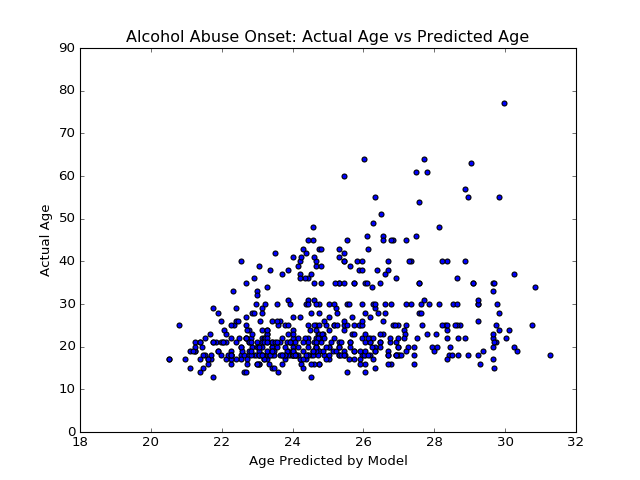

In [18]:
####################################################################
#Visualising the Predicted Outcome vs the Actual Outcome
####################################################################

%matplotlib notebook
import matplotlib.pyplot as plt

#plt.ioff() # in VS2015 Interactive window, we need this command so that charts will display
plt.scatter(model.predict(pred_train.values), tar_train.S2BQ3A.values)
plt.title('Alcohol Abuse Onset: Actual Age vs Predicted Age')
plt.xlabel('Age Predicted by Model')
plt.ylabel('Actual Age')
plt.show()

<IPython.core.display.Javascript object>


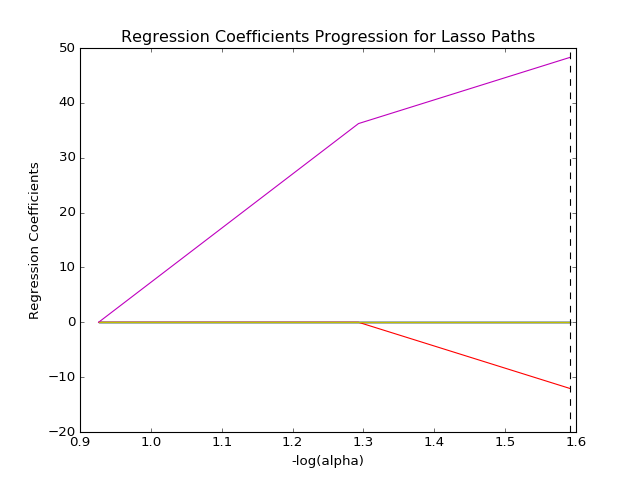

In [19]:
####################################################################
#Visualising the Reduction of Coefficients As Alpha is Increased
####################################################################

%matplotlib notebook
import matplotlib.pyplot as plt

# plot coefficient progression

m_log_alphas = -np.log10(model.alphas_)#ax = plt.gca()
plt.plot(m_log_alphas, model.coef_path_.T)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k', label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')
plt.show()